In [141]:
import numpy, pandas, json

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib_venn import venn3

In [161]:
random_seed = 144
n_folds=10    
optimisation_score='recall'
scoring_metrics=['recall', 'roc_auc', 'precision', ]
mapping_dict = {'S':0, 'R':1}
folds = StratifiedKFold(n_splits=n_folds, random_state=random_seed, shuffle=True)
line=[]
very_major_errors = {}
major_errors = {}

In [162]:
X={}
Y={}
Z={}

for i in ['train', 'test', 'validation', 'mic']:
    X[i]={}
    Y[i]={}
    Z[i]={}
    with open('data/ds-'+i+'.npy', 'rb') as f:
        Y[i]['input'] = numpy.load(f)
        X[i]['input'] = numpy.load(f)
        Z[i]['input'] = numpy.load(f, allow_pickle=True)

suspectpza={}
for i in ['train', 'test', 'validation', 'mic']:
    suspectpza[i]={}
    with open('data/suspectpza-'+i+'.npy', 'rb') as f:
        suspectpza[i]['input'] = numpy.load(f)
        suspectpza[i]['predicted'] = numpy.load(f)


In [150]:
def construct_line(model_name , dataset, scores, y, best_parameters):
  
    row=[]
    row.append(model_name)
    row.append(dataset)

    if scores is not None:
        for i in scores:
            row.append(i)
    else:        
        if 'predicted' in y.keys():
            row.append(100*recall_score(y['input'],y['predicted'],pos_label=1))   
            row.append(None)     
            row.append(100*recall_score(y['input'],y['predicted'],pos_label=0))        
            row.append(None)
        else:
            row.append(None)
            row.append(None)
            row.append(None)
            row.append(None)
        if 'scores' in y.keys():
            row.append(100*roc_auc_score(y['input'],y['scores']))
        else:
            row.append(None)
        row.append(None)    
            
    table = confusion_matrix(y['input'], y['predicted'])
    row.append(table[0][0])
    row.append(table[0][1])
    row.append(table[1][0])
    row.append(table[1][1])
    row.append(json.dumps(best_parameters))
    return row

In [163]:
def tune_model(line, model, model_name, X, Y, param_grid, folds, optimisation_score):

    # hyperparameter tuning
    grid_search = GridSearchCV( model, 
                                param_grid, 
                                cv=folds, 
                                n_jobs=-1, 
                                return_train_score=True,
                                scoring=scoring_metrics,
                                refit=optimisation_score )

    grid_search.fit(X['train']['input'], Y['train']['input'])

    cv_results = pandas.DataFrame(grid_search.cv_results_)

    # get the best model
    best_model = grid_search.best_estimator_

    for dataset in ['train', 'test', 'validation', 'mic']: #, 'orphan']:
        
        if dataset=='train':
            scores = []
            for score in scoring_metrics:
                mean_score = cv_results[cv_results['rank_test_'+score]==1]['mean_test_'+score].values[0]
                std_score = cv_results[cv_results['rank_test_'+score]==1]['std_test_'+score].values[0]
                scores.append(100*mean_score)
                scores.append(100*std_score)
        else:
            scores=None
        Y[dataset]['predicted'] = best_model.predict(X[dataset]['input'])
        Y[dataset]['scores'] = best_model.predict_proba(X[dataset]['input'])[:,1]

        row = construct_line(model_name , dataset, scores, Y[dataset], grid_search.best_params_)
        line.append(row)

    return(line, best_model)

In [164]:
model_logistic_regression = LogisticRegression(random_state=random_seed, class_weight='balanced')

param_grid = [ 
                {   'penalty': ['l1', 'l2'],
                    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'], 
                    'C': numpy.logspace(-3,3,7)
                } 
            ]

line, best_LR = tune_model(line, model_logistic_regression, "LR", X, Y, param_grid, folds, optimisation_score)


/Users/fowler/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fowler/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fowler/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fowler/Library/Python/3.10/lib/python/site-packages/sklearn/met

In [165]:
y_predicted = best_LR.predict(X['test']['input'])
very_major_errors['LR'] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==0)])
major_errors['LR'] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==1)])

In [62]:
# model_random_forest = RandomForestClassifier(random_state=random_seed, class_weight='balanced')

# param_grid = [ 
#                 { 'n_estimators': [2, 5, 10, 50, 100, 200, 500],                        
#                 'max_features': [1, 2, 4, 8, 16, 20],
#                 'max_depth':[1,2,3,4,5,6],
#                 'bootstrap':[True,False] } 
#             ]

# line = tune_model(line, model_random_forest, 'RF', X, Y, param_grid, folds, optimisation_score)


In [166]:
model_nn = MLPClassifier(random_state=random_seed)

param_grid = [ 
        {   'solver': ['lbfgs'],
            'max_iter': [400, 800],
            'alpha':10.0 ** -numpy.arange(1, 7),
            'hidden_layer_sizes':[(100,), (20,10,5), (10,5), (20,10), (100,50,10)] ,
            'activation':['relu','logistic','tanh']} 
    ]

line, best_NN = tune_model(line, model_nn, "NN", X, Y, param_grid, folds, optimisation_score)

/Users/fowler/Library/Python/3.10/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/fowler/Library/Python/3.10/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/fowler/Library/Python/3.10/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs faile

In [167]:
y_predicted = best_NN.predict(X['test']['input'])
very_major_errors['NN'] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==0)])
major_errors['NN'] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==1)])

In [168]:
model_xgb = XGBClassifier()

param_grid = [ 
        {   'n_estimators': [25, 50, 100, 150, 200],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1],
            'max_depth':[2,4,5,6,8],
            'min_child_weight': [0, 0.1, 1, 10],
            'learning_rate':[0.005, 0.01, 0.05, 0.075, 0.1, 0.125, 0.1] } 
    ]

line, best_XB = tune_model(line, model_xgb, "XB", X, Y, param_grid, folds, optimisation_score)

In [169]:
y_predicted = best_XB.predict(X['test']['input'])
very_major_errors['XB'] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==0)])
major_errors['XB'] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==1)])

In [170]:
len(very_major_errors['XB']), len(very_major_errors['NN']), len(very_major_errors['LR']), 

(23, 24, 22)

In [173]:
len(very_major_errors['XB'].intersection(very_major_errors['LR']).intersection(very_major_errors['NN'])), very_major_errors['XB'].intersection(very_major_errors['LR']).intersection(very_major_errors['NN'])


(15,
 {'A30S',
  'A38S',
  'D110N',
  'E127D',
  'E174G',
  'H82L',
  'N112S',
  'N118Y',
  'P115A',
  'R29C',
  'S18T',
  'S32I',
  'S88T',
  'T76S',
  'V93L'})

In [172]:
len(major_errors['XB']),len(major_errors['NN']),len(major_errors['LR']), len(major_errors['XB'].intersection(major_errors['LR']).intersection(major_errors['NN'])), major_errors['XB'].intersection(major_errors['LR']).intersection(major_errors['NN'])

(24,
 32,
 29,
 15,
 {'A178D',
  'A28P',
  'A46S',
  'A79T',
  'F58Y',
  'G17S',
  'G17V',
  'G23A',
  'L172Q',
  'L19V',
  'L35Q',
  'L35R',
  'N11H',
  'N11I',
  'S32R'})

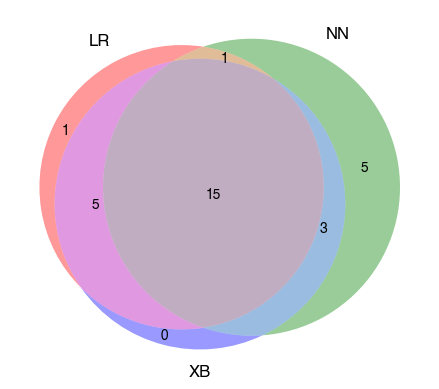

In [174]:
venn3([very_major_errors['LR'], very_major_errors['NN'], very_major_errors['XB']], set_labels=['LR','NN','XB'])

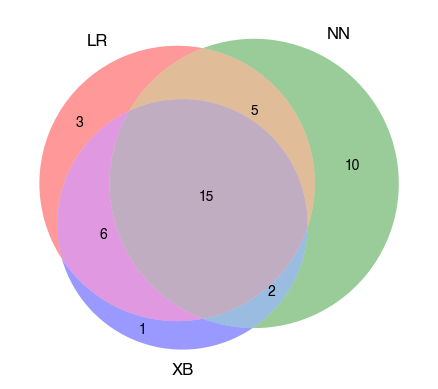

In [175]:
venn3([major_errors['LR'], major_errors['NN'], major_errors['XB']], set_labels=['LR','NN','XB'])

In [176]:
for dataset in ['train', 'test', 'validation', 'mic']:
    line.append(construct_line('SP', dataset, None, suspectpza[dataset], None))

In [177]:
results = pandas.DataFrame(line, columns=['model', 'dataset', 'sensitivity_mean', 'sensitivity_std', 'specificity_mean', 'specificity_std' ,'roc_auc_mean', 'roc_auc_std','TN','FP','FN','TP', 'model_parameters'])
results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters
0,LR,train,78.800000,6.200717,84.357576,5.114400,82.484060,7.276335,180,38,49,197,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline..."
1,LR,test,78.640777,NaN,70.103093,NaN,82.684416,NaN,68,29,22,81,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline..."
2,LR,validation,97.557471,NaN,43.845535,NaN,80.006802,NaN,545,698,68,2716,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline..."
3,LR,mic,100.000000,NaN,14.285714,NaN,68.000000,NaN,1,6,0,50,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline..."
4,NN,train,78.916667,5.147950,83.682792,5.282488,81.760028,7.781499,218,0,0,246,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid..."
5,NN,test,76.699029,NaN,67.010309,NaN,79.861876,NaN,65,32,24,79,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid..."
6,NN,validation,94.755747,NaN,48.833467,NaN,77.079895,NaN,607,636,146,2638,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid..."
7,NN,mic,96.000000,NaN,28.571429,NaN,69.714286,NaN,2,5,2,48,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid..."
8,XB,train,79.216667,5.468115,85.781926,4.776355,83.502833,7.880220,192,26,43,203,"{""learning_rate"": 0.05, ""max_depth"": 4, ""min_c..."
9,XB,test,77.669903,NaN,75.257732,NaN,82.764488,NaN,73,24,23,80,"{""learning_rate"": 0.05, ""max_depth"": 4, ""min_c..."


In [178]:
results['diagnostic_odds_ratio'] = (results['TN']*results['TP'])/(results['FN']*results['FP'])
results.to_csv('results.csv')
results[:3]

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio
0,LR,train,78.800000,6.200717,84.357576,5.1144,82.484060,7.276335,180,38,49,197,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",19.044039
1,LR,test,78.640777,NaN,70.103093,NaN,82.684416,NaN,68,29,22,81,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",8.633229
2,LR,validation,97.557471,NaN,43.845535,NaN,80.006802,NaN,545,698,68,2716,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",31.186162


In [179]:
results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio
0,LR,train,78.800000,6.200717,84.357576,5.114400,82.484060,7.276335,180,38,49,197,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",19.044039
1,LR,test,78.640777,NaN,70.103093,NaN,82.684416,NaN,68,29,22,81,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",8.633229
2,LR,validation,97.557471,NaN,43.845535,NaN,80.006802,NaN,545,698,68,2716,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",31.186162
3,LR,mic,100.000000,NaN,14.285714,NaN,68.000000,NaN,1,6,0,50,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",inf
4,NN,train,78.916667,5.147950,83.682792,5.282488,81.760028,7.781499,218,0,0,246,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",inf
5,NN,test,76.699029,NaN,67.010309,NaN,79.861876,NaN,65,32,24,79,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",6.686198
6,NN,validation,94.755747,NaN,48.833467,NaN,77.079895,NaN,607,636,146,2638,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",17.244615
7,NN,mic,96.000000,NaN,28.571429,NaN,69.714286,NaN,2,5,2,48,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",9.600000
8,XB,train,79.216667,5.468115,85.781926,4.776355,83.502833,7.880220,192,26,43,203,"{""learning_rate"": 0.05, ""max_depth"": 4, ""min_c...",34.862254
9,XB,test,77.669903,NaN,75.257732,NaN,82.764488,NaN,73,24,23,80,"{""learning_rate"": 0.05, ""max_depth"": 4, ""min_c...",10.579710


In [180]:
for metric in ['sensitivity', 'specificity', 'roc_auc']:
    for dataset in ['test', 'train', 'validation']:
        colour='#888888'
        fig = plt.figure(figsize=(2.2, 3.5))
        axes = plt.gca()
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.get_yaxis().set_visible(False)
        x=range(4)
        x=results[(results.dataset==dataset) & (results.model!='RF') & (results.model!='SP')].model
        y=results[(results.dataset==dataset) & (results.model!='RF') & (results.model!='SP')][metric+'_mean']
        e=results[(results.dataset==dataset) & (results.model!='RF') & (results.model!='SP')][metric+'_std']
        axes.set_ylim([0,100])
        axes.bar(x,y, label=y, edgecolor=colour, color='None',linewidth=2)

        if e.sum()>0:
            axes.errorbar(x,y,yerr=e, fmt='.',color=colour,linewidth=2)
            for (i,j) in zip(x,y+e):
                axes.text(i,j+2,'%.1f' % j,ha='center',color=colour)

        else:
            for (i,j) in zip(x,y):
                axes.text(i,j+2,'%.1f' % j,ha='center',color=colour)

        fig.savefig('pdf/fig-3-'+dataset+'-'+metric+'.pdf', bbox_inches="tight")
        plt.close()

In [181]:
for metric in ['sensitivity', 'specificity']:
    for dataset in ['test', 'train', 'validation']:
        colour=['#888888','#888888','#888888','pink']
        fig = plt.figure(figsize=(3.2, 3.5))
        axes = plt.gca()
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.get_yaxis().set_visible(False)
        x=range(4)
        x=results[(results.dataset==dataset) & (results.model!='RF')].model
        y=results[(results.dataset==dataset) & (results.model!='RF')][metric+'_mean']
        e=results[(results.dataset==dataset) & (results.model!='RF')][metric+'_std']
        axes.set_ylim([0,100])
        axes.bar(x,y, label=y, edgecolor=colour, color='None',linewidth=2)

        if e.sum()>0:
            axes.errorbar(x,y,yerr=e, fmt='.',color='#888888',linewidth=2)
            for (i,j,e,c) in zip(x,y,e,colour):
                if e>0:
                    axes.text(i,j+e+2,'%.1f' % j,ha='center',color=c)
                else:
                    axes.text(i,j+2,'%.1f' % j,ha='center',color=c)
 
        else:
            for (i,j,c) in zip(x,y,colour):                
                axes.text(i,j+2,'%.1f' % j,ha='center',color=c)

        fig.savefig('pdf/fig-3-'+dataset+'-'+metric+'-suspectpza.pdf', bbox_inches="tight")
        plt.close()

In [85]:
for metric in ['diagnostic_odds_ratio']:
    for dataset in ['test', 'train', 'validation']:
        colour=['#888888','#888888','#888888','#888888','pink']
        fig = plt.figure(figsize=(2.2, 3.5))
        axes = plt.gca()
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.get_yaxis().set_visible(False)
        x=range(4)
        x=results[(results.dataset==dataset) & (results.model!='RF') & (results.model!='SP')].model
        y=results[(results.dataset==dataset) & (results.model!='RF') & (results.model!='SP')].diagnostic_odds_ratio
        # axes.set_ylim([0,1])
        axes.bar(x,y, label=y, edgecolor=colour, color='None',linewidth=2)

        # if e.sum()>0:
        #     axes.errorbar(x,y,yerr=e, fmt='.',color='k',linewidth=2)
        #     for (i,j,c) in zip(x,y+e,colour):
        #         axes.text(i,j+0.02,'%.2f' % j,ha='center',color=c)

        # else:
        for (i,j,c) in zip(x,y,colour):
            axes.text(i,j+0.1,'%.1f' % j,ha='center',color=c)

        fig.savefig('pdf/fig-3-'+dataset+'-'+metric+'.pdf', bbox_inches="tight")
        plt.close()

posx and posy should be finite values
posx and posy should be finite values


In [182]:
results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio
0,LR,train,78.800000,6.200717,84.357576,5.114400,82.484060,7.276335,180,38,49,197,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",19.044039
1,LR,test,78.640777,NaN,70.103093,NaN,82.684416,NaN,68,29,22,81,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",8.633229
2,LR,validation,97.557471,NaN,43.845535,NaN,80.006802,NaN,545,698,68,2716,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",31.186162
3,LR,mic,100.000000,NaN,14.285714,NaN,68.000000,NaN,1,6,0,50,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",inf
4,NN,train,78.916667,5.147950,83.682792,5.282488,81.760028,7.781499,218,0,0,246,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",inf
5,NN,test,76.699029,NaN,67.010309,NaN,79.861876,NaN,65,32,24,79,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",6.686198
6,NN,validation,94.755747,NaN,48.833467,NaN,77.079895,NaN,607,636,146,2638,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",17.244615
7,NN,mic,96.000000,NaN,28.571429,NaN,69.714286,NaN,2,5,2,48,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",9.600000
8,XB,train,79.216667,5.468115,85.781926,4.776355,83.502833,7.880220,192,26,43,203,"{""learning_rate"": 0.05, ""max_depth"": 4, ""min_c...",34.862254
9,XB,test,77.669903,NaN,75.257732,NaN,82.764488,NaN,73,24,23,80,"{""learning_rate"": 0.05, ""max_depth"": 4, ""min_c...",10.579710


In [86]:
for idx,row in results.iterrows():

    fig = plt.figure(figsize=(1.5, 1.5))
    axes = plt.gca()

    axes.add_patch(Rectangle((0,0),1,1,fc='#e41a1c',alpha=0.7))
    axes.add_patch(Rectangle((0,1),1,1,fc='#4daf4a',alpha=0.7))
    axes.add_patch(Rectangle((1,1),1,1,fc='#fc9272',alpha=0.7))
    axes.add_patch(Rectangle((1,0),1,1,fc='#4daf4a',alpha=0.7))

    axes.set_xlim([0,2])
    axes.set_ylim([0,2])

    axes.set_xticks([0.5,1.5],labels=['R','S'])
    axes.set_yticks([0.5,1.5],labels=['S','R'])

    axes.text(0.5,0.5,row['FN'],ha='center',va='center')
    axes.text(1.5,0.5,row['TN'],ha='center',va='center')
    axes.text(0.5,1.5,row['TP'],ha='center',va='center')
    axes.text(1.5,1.5,row['FP'],ha='center',va='center')

    fig.savefig('pdf/truthtable-'+row['dataset']+'-'+row['model']+'.pdf', bbox_inches='tight')
    plt.close()

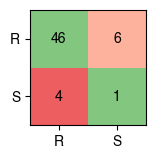